# Customer Segmentation Analysis

Customer segmentation is a method to divide a customer base into distinct groups that share similar characteristics or purchasing behaviors. In the context of retail supply chain analytics, segmentation helps businesses understand who their customers are, how they shop, and what strategies can maximize their lifetime value.\
This notebook applies clustering techniques to transactional data, focusing on RFM (Recency, Frequency, Monetary) analysis. By transforming raw sales records into customer-level features, we aim to uncover meaningful patterns that can guide marketing, retention, and operational decisions.\
Segmentation is not just a technical exercise—it provides actionable insights for resource allocation, campaign design, and customer relationship management. The outcome is a set of well-defined customer groups that can be targeted with tailored strategies.

**Goals**
- **Prepare customer-level dataset** by aggregating transactions into RFM metrics (Recency, Frequency, Monetary).  
- **Normalize features** to ensure fair comparison across customers.  
- **Apply clustering algorithms** (e.g., KMeans) to identify distinct customer segments.  
- **Determine optimal number of clusters** using methods such as the Elbow Method and silhouette score.  
- **Profile each cluster** to interpret customer characteristics and behaviors.  
- **Translate insights into business strategies** for marketing, promotions, retention, and supply chain planning.  

**Expected Outcome:**  
A validated segmentation model that categorizes customers into actionable groups, enabling data-driven strategies to improve customer engagement, optimize operations, and drive long-term business growth.

In [1]:
# Import some libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [5]:
# Load dataset

sales = pd.read_csv("../data/cleaned/sales_clean.csv")
sales["Order Date"] = pd.to_datetime(sales["Order Date"])
sales.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Retail Sales People,Product ID,Category,Sub-Category,Product Name,Returned,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-08-11,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Cassandra Brandow,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,Not,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-08-11,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Cassandra Brandow,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Not,731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-12-06,2016-12-06,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Anna Andreadi,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,Not,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-11-10,2015-11-10,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Cassandra Brandow,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,Not,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-11-10,2015-11-10,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Cassandra Brandow,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,Not,22.3680,2,0.20,2.5164


In [6]:
# Aggregate data to customer level
rfm = sales.groupby("Customer ID").agg({
    "Order Date": lambda x: (sales["Order Date"].max() - x.max()).days,  # Recency
    "Order ID": "count",                                                 # Frequency
    "Sales": "sum"                                                       # Monetary
}).reset_index()

In [7]:
# Rename columns
rfm.columns = ["Customer ID", "Recency", "Frequency", "Monetary"]
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,AA-10315,184,11,5563.560
1,AA-10375,48,15,1056.390
2,AA-10480,259,12,1790.512
3,AA-10645,233,18,5086.935
4,AB-10015,445,6,886.156


In [8]:
# Scaling features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])

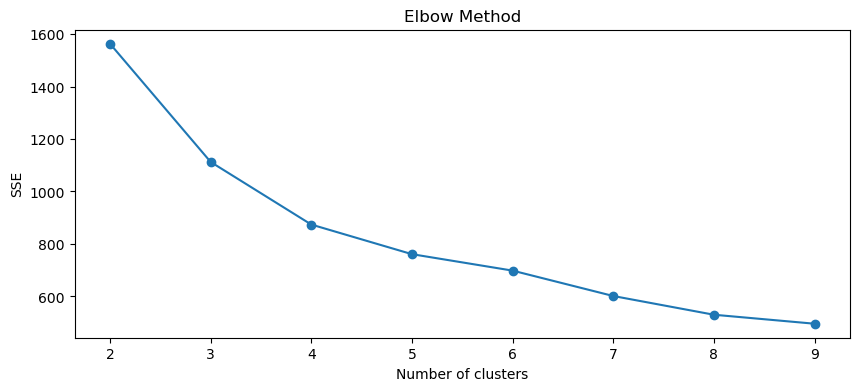

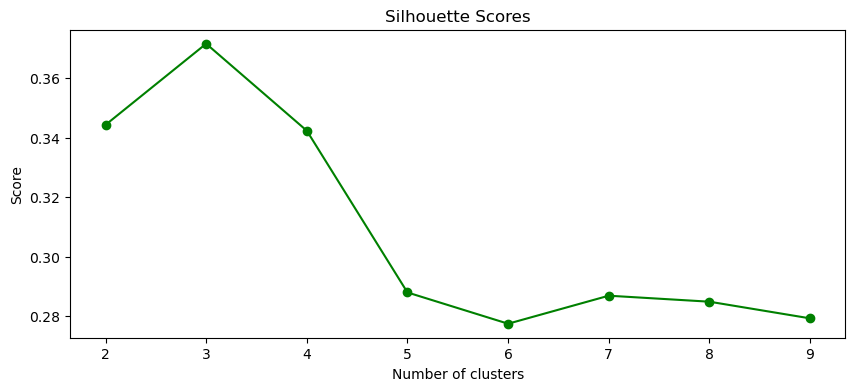

In [9]:
# Determine optimal clusters (Elbow Method + silhouette)
sse = []
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(10,4))
plt.plot(range(2,10), sse, marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

# Plot silhouette scores
plt.figure(figsize=(10,4))
plt.plot(range(2,10), silhouette_scores, marker="o", color="green")
plt.title("Silhouette Scores")
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.show()

In [10]:
# Choose optimal k
kmeans = KMeans(n_clusters=3, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)
rfm.head()

,Customer ID,Recency,Frequency,Monetary,Cluster
0,AA-10315,184,11,5563.560,1
1,AA-10375,48,15,1056.390,1
2,AA-10480,259,12,1790.512,1
3,AA-10645,233,18,5086.935,0
4,AB-10015,445,6,886.156,2


In [11]:
# Summary statistics per cluster
cluster_profile = rfm.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean",
    "Customer ID": "count"
}).reset_index()

cluster_profile

,Cluster,Recency,Frequency,Monetary,Customer ID
0,0,86.426667,19.680000,5568.311782,225
1,1,107.997812,10.210066,1848.001597,457
2,2,547.441441,8.108108,1799.945763,111


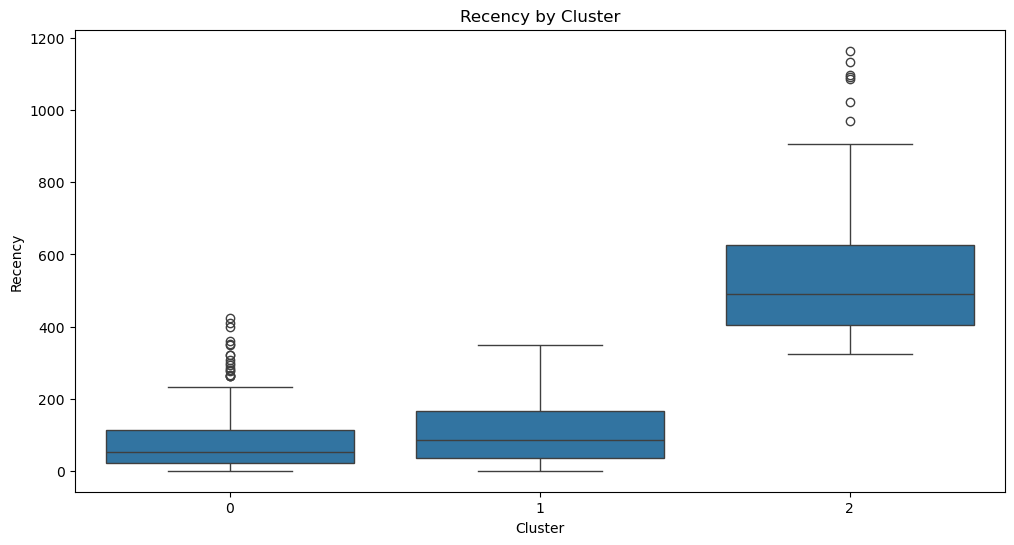

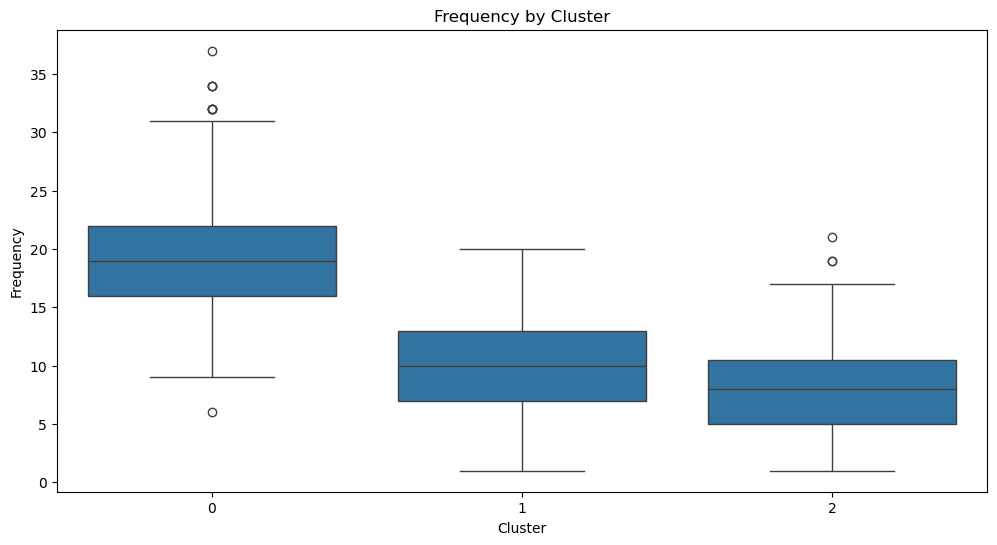

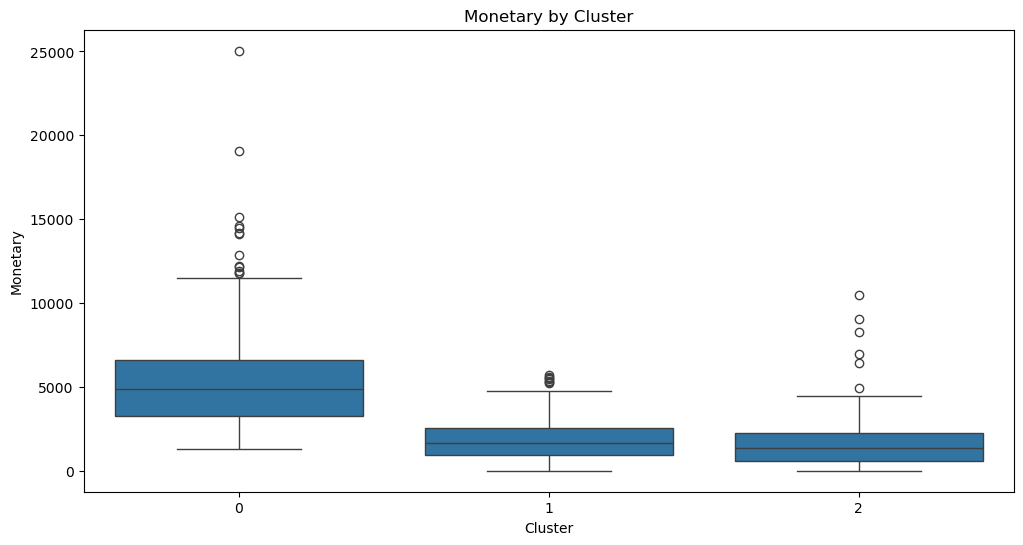

In [12]:
# Visualize distributions
plt.figure(figsize=(12,6))
sns.boxplot(x="Cluster", y="Recency", data=rfm)
plt.title("Recency by Cluster")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x="Cluster", y="Frequency", data=rfm)
plt.title("Frequency by Cluster")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x="Cluster", y="Monetary", data=rfm)
plt.title("Monetary by Cluster")
plt.show()

# Closing & Strategic Insights

This segmentation confirms three distinct customer groups, each requiring tailored strategies to maximize business impact:

- **Cluster 0 – High-value loyal customers**  
  - **Recency:** ~86 days → relatively recent transactions  
  - **Frequency:** highest, ~20 transactions → very active  
  - **Monetary:** strongest, ~5,588 → major revenue contributors  
  - **Customer count:** 225  
  **Strategy:** strengthen loyalty programs, exclusive offers, and long-term retention. They are the backbone of business revenue.

- **Cluster 1 – Active mid-value customers**  
  - **Recency:** ~108 days → moderately active  
  - **Frequency:** ~12 transactions → consistent but not intensive  
  - **Monetary:** mid-level, ~1,480  
  - **Customer count:** 111  
  **Strategy:** encourage upselling and cross-selling, seasonal promotions to increase purchase value.

- **Cluster 2 – Inactive but high-spend customers**  
  - **Recency:** ~547 days → very inactive  
  - **Frequency:** ~1 transaction → minimal engagement  
  - **Monetary:** relatively high, ~1,800 → large single purchases but rare  
  - **Customer count:** 111  
  **Strategy:** launch reactivation campaigns, bundle discounts, and personalized outreach to bring them back.

---

**Key takeaway:**  
With 3 clusters, segmentation is both stable and interpretable. Boxplots confirm the differences: Cluster 0 is highly active and valuable; Cluster 1 is moderately active with mid-value spending; and Cluster 2 is inactive but capable of high single-purchase amounts.

**Practical implication:**  
This segmentation provides a foundation for targeted marketing, personalized CRM, and adaptive supply chain planning. By tailoring strategies to each segment, businesses can improve retention, maximize customer lifetime value, and optimize operational efficiency. Applying the PDCA cycle strengthens execution: **plan** by defining the three segments and objectives (retention, upselling, reactivation); **do** by implementing loyalty rewards, targeted promotions, and reactivation offers; **check** by monitoring KPIs such as retention rates, average order value, and reactivation success; and **act** by standardizing effective programs, refining weaker strategies, and embedding insights into future segmentation cycles, ensuring continuous improvement and sustainable growth.